# Step 4: log2 scaling

Made by: Cynthia Soto <br>
Date: March 19, 2021 <br>
Last md: June 1, 2022 <br>

**Assumptions:** <br>
1. Data are a tvs file with the TPM standardized values.

**Code goal:** <br>
1. It apply a Log2(TPM + 1) transformation.<br>
2. Get some stats and distributions.   <br>
    1. If necessary it removes samples with atypical distributions among the dataset. <br>
3. Plot.

In [1]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [2]:
# Set the directory to parse and the base_name of the dataset 
# notice all plots and files will use this base_name to label objects)

#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the main and temporary files. 

###   Choose what dataset you are going to process
#general_titles="healthy"
general_titles="infected"

In [3]:
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


### Declare functions

In [4]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [5]:
# Filter a dataframe by column value (I use a cutoff threshold)
def filter_low_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

def filter_high_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] <= v]
    return df_cut

In [6]:
# Plot a bar-chart as the result of the dataframe describe() function over an expression array (df)
def plot_intercuartile_bar(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="max", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

# Set ID index as "ID" to trigger the describe() function over a dataframe    
def df_with_label_ID(df_stat):
    try:
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [7]:
# Plot a line-chart with the mean and std.dev as the result of the dataframe describe() function over an expression array (df)
def plot_mean_sdev_line(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
  
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [8]:
# plot the maximum values of a given df
def plot_maximum_values(df, title, perc):
    maxValues = df.max(axis = 1)
    #maxValues.sort_values(axis=0, ascending=True)
    #print(maxValues)
    maxValues.plot()
    plt.title("Matrix C: maximum TPM values for Athal " + title, fontsize = 14)
    plt.ylabel("Maximum TPM", fontsize = 14)
    plt.xlabel("Genes", fontsize = 14)
    if perc > 0: 
        plt.axhline(y=perc, color='b', linestyle='-')
    
    return

In [9]:
 #Build a violin subplot chat with the option to include a swarmplot distribution
def violin_plot_inf(dfx, s_type, atypical, b_swarm, ylab):
    # @dfx: array (expr.matrix)
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")
    plt.rc('xtick',labelsize=1)
    plt.rc('ytick',labelsize=13)
    
    if atypical==2:
        fig = plt.figure(figsize=(4, 4))
        gs = fig.add_gridspec(1, 3)        # grid spaces for 3 samples
    elif atypical==1:
        fig = plt.figure(figsize=(12, 4))
        gs = fig.add_gridspec(1, 14)       # grid spaces for 14 samples
    elif atypical==0:
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(1, 17)       # grid spaces for 17 samples

    if atypical==0 or atypical==1:   #(1 is not plot atypical samples)
        ## Assign the column to a pandas serie for botrytis
        Bc12 = dfx['Bc12']
        Bc12r = dfx['Bc12.1']
        Bc18 = dfx['Bc18']
        Bc18r = dfx['Bc18.1']
        Bc24 = dfx['Bc24']
        Bc24r = dfx['Bc24.1']
        ## Assign the column to a pandas serie for Colletotrichum
        Ch22 = dfx['Ch22']
        Ch22r1 = dfx['Ch22.1']
        Ch22r2 = dfx['Ch22.2']
        Ch22r3 = dfx['Ch22.3']
        Ch40 = dfx['Ch40']
        Ch40r1 = dfx['Ch40.1']
        Ch40r2 = dfx['Ch40.2']
        Ch40r3 = dfx['Ch40.3']
    if atypical==0 or atypical==2:
        print("Preparing series for all atypical")
        ## Assign the column to a pandas serie for Ss
        Ss = dfx['Ss30']
        Ssr1 = dfx['Ss30.1']
        Ssr2 = dfx['Ss30.2'];

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    if atypical==2:           # atypicals
        ## Sclerotinia
        #ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)
        sns.violinplot(data=Ss, palette='pink')
        if b_swarm: sns.swarmplot(data=Ss, color="k", alpha=0.8)
        ax1.set_xlabel("Ss30", fontsize=14)
        ax1.set_ylabel(ylab,fontsize=16)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=Ssr1, palette='pink')
        if b_swarm: sns.swarmplot(data=Ssr1, color="k", alpha=0.8)
        ax2.set_xlabel("Ss30.1", fontsize=14)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=Ssr2, palette='pink')
        if b_swarm: sns.swarmplot(data=Ssr2, color="k", alpha=0.8)
        ax3.set_xlabel("Ss30.2", fontsize=14)
    elif atypical==1 or atypical==0:     
        # 1 = all with out atypical samples
        # 0 = all samples       
        #ax1 = fig.add_subplot(gs[0, 0])
        sns.violinplot(data=Bc12, palette='Accent')
        ax1.set_xlabel("Bc12", fontsize=14)
        ax1.set_ylabel(ylab,fontsize=16)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=Bc12r, palette='Accent')
        ax2.set_xlabel("Bc12.1", fontsize=14)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=Bc18, palette='Reds')
        ax3.set_xlabel("Bc18", fontsize=14)
        #ax3.set_title('**Zeros in common removed and Q3 threshold',fontsize=13)

        ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
        sns.violinplot(data=Bc18r, palette='Reds')
        ax4.set_xlabel("Bc18.1", fontsize=14)

        ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
        sns.violinplot(data=Bc24, palette='Greens')
        ax5.set_xlabel("Bc24", fontsize=14)

        ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
        sns.violinplot(data=Bc24r, palette='Greens')
        ax6.set_xlabel("Bc24.1", fontsize=14)

        ## Colletrotrichum
        ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
        sns.violinplot(data=Ch22, palette='Purples')
        ax7.set_xlabel("Ch22", fontsize=14)

        ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
        sns.violinplot(data=Ch22r1, palette='Purples')
        ax8.set_xlabel("Ch22.1", fontsize=14)

        ax9 = fig.add_subplot(gs[0, 8])
        sns.violinplot(data=Ch22r2, palette='Purples')
        ax9.set_xlabel("Ch22.2", fontsize=14)

        ax10 = fig.add_subplot(gs[0, 9], sharey=ax1)
        sns.violinplot(data=Ch22r3, palette='Purples')
        ax10.set_xlabel("Ch22.3", fontsize=14)

        ax11 = fig.add_subplot(gs[0, 10], sharey=ax1)
        sns.violinplot(data=Ch40, palette='Blues')
        ax11.set_xlabel("Ch40", fontsize=14)

        ax12 = fig.add_subplot(gs[0, 11], sharey=ax1)
        sns.violinplot(data=Ch40r1, palette='Blues')
        ax12.set_xlabel("Ch40.1", fontsize=14)

        ax13 = fig.add_subplot(gs[0, 12], sharey=ax1)
        sns.violinplot(data=Ch40r2, palette='Blues')
        ax13.set_xlabel("Ch40.2", fontsize=14)

        ax14 = fig.add_subplot(gs[0, 13], sharey=ax1)
        sns.violinplot(data=Ch40r3, palette='Blues')
        ax14.set_xlabel("Ch40.3", fontsize=14)      
        if atypical==0:
            ## Sclerotinia
            #ax15 = fig.add_subplot(gs[0, 0], sharey=ax15)
            ax15 = fig.add_subplot(gs[0, 14], sharey=ax1)
            sns.violinplot(data=Ss, palette='pink')
            ax15.set_xlabel("Ss30", fontsize=14)

            ax16 = fig.add_subplot(gs[0, 15], sharey=ax1)
            sns.violinplot(data=Ssr1, palette='pink')
            ax16.set_xlabel("Ss30.1", fontsize=14)

            ax17 = fig.add_subplot(gs[0, 16], sharey=ax1)
            sns.violinplot(data=Ssr2, palette='pink')
            ax17.set_xlabel("Ss30.2", fontsize=14)   

        if atypical==2:  # atypicals 
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            fig.suptitle(s_type + ". Violin plots with KDE for Ss30 samples "+general_titles, fontsize=18)
        else:            # all or w/o atypicals
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            plt.setp(ax4.get_yticklabels(), visible=False)
            plt.setp(ax5.get_yticklabels(), visible=False)
            plt.setp(ax6.get_yticklabels(), visible=False)
            plt.setp(ax7.get_yticklabels(), visible=False)
            plt.setp(ax8.get_yticklabels(), visible=False)
            plt.setp(ax9.get_yticklabels(), visible=False)
            plt.setp(ax10.get_yticklabels(), visible=False)
            plt.setp(ax11.get_yticklabels(), visible=False)
            plt.setp(ax12.get_yticklabels(), visible=False)
            plt.setp(ax13.get_yticklabels(), visible=False)
            plt.setp(ax14.get_yticklabels(), visible=False)   
            if atypical==0:
                plt.setp(ax15.get_yticklabels(), visible=False)
                plt.setp(ax16.get_yticklabels(), visible=False)
                plt.setp(ax17.get_yticklabels(), visible=False)                     
                fig.suptitle(s_type + ". Violin plots with KDE for A.thaliana "+ general_titles, fontsize=18)
            else: 
                fig.suptitle(s_type + ". Violin plots with KDE for A.thaliana infected / No Ss30 samples", fontsize=18) 
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    
    return

In [10]:
# Build a violin subplot chat with the option to include a swarmplot distribution
def violin_plot_healthy(dfx, s_type, atypical, b_swarm, ylab):
    # @dfx: array (expr.matrix)
    # @s_type: type of matrix A, B, C, D or E
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(1, 8)            # grid spaces for 8 samples    
    plt.rc('xtick',labelsize=1)
    plt.rc('ytick',labelsize=13)

    # prepare series ############################################################################################      
    H12=dfx['healthy12']
    H12r=dfx['healthy12.1']
    H18=dfx['healthy18']
    H18r=dfx['healthy18.1']
    H24=dfx['healthy24']
    H24r=dfx['healthy24.1']
    H30=dfx['healthy30']
    H30r=dfx['healthy30.1']

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    sns.violinplot(data=H12, palette='Reds')
    ax1.set_xlabel("H12",fontsize=14)
    ax1.set_ylabel(ylab,fontsize=16)

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    sns.violinplot(data=H12r, palette='Greens')
    ax2.set_xlabel("H12.1",fontsize=14)

    ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
    sns.violinplot(data=H18, palette='pink')
    ax3.set_xlabel("H18",fontsize=14)

    ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
    sns.violinplot(data=H18r, palette='Accent')
    ax4.set_xlabel("H18.1",fontsize=14)

    ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
    sns.violinplot(data=H24, palette='Reds')
    ax5.set_xlabel("H24",fontsize=14)

    ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
    sns.violinplot(data=H24r, palette='Greens')
    ax6.set_xlabel("H24.1",fontsize=14)

    ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
    sns.violinplot(data=H30, palette='pink')
    ax7.set_xlabel("H30",fontsize=14)

    ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
    sns.violinplot(data=H30r, palette='Accent')
    ax8.set_xlabel("H30.1",fontsize=14)

    # prepare labels #####################################################################################
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    plt.setp(ax5.get_yticklabels(), visible=False)
    plt.setp(ax6.get_yticklabels(), visible=False)
    plt.setp(ax7.get_yticklabels(), visible=False)
    plt.setp(ax8.get_yticklabels(), visible=False)
    fig.suptitle(s_type + ". Violin plot with KDE for A.thaliana "+ general_titles, fontsize=18)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    
    return

In [35]:
# Plot the distributions: values are TPM normalized
def plot_KDE(df, samples, y_label):
    ## @df: the array(df) to be plotted (w/o column gene's names)
    ## @samples: the names to be displayed in the leyend label
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the "y" axis label.
    
    # Plot Designs for paper figure
    plt.figure(figsize=(7,4), dpi= 300)
    xlab_fs = 11
    ylab_fs = 11
    xtick_fs = 10
    #leyend_fs = 8
    titulo = 'Histogram with KDE for log2 norm. & stand. dataset' 
    
    sns.set_style("white")
    kwargs=dict(hist_kws={"alpha":0.5, "lw": 2})
    plt.rc('xtick',labelsize = xtick_fs)
    plt.rc('ytick',labelsize = xtick_fs)
    
    np_array = df.to_numpy()         # samples
    x = len(samples)

    for i in range(1, x):
        sample_data = np_array[:,i]
        sns.distplot(sample_data, label = samples[i], **kwargs)   #color="dodgerblue", 
    
    plt.title(titulo, fontsize = 12);
    plt.xlabel(y_label,fontsize = xlab_fs);
    plt.ylabel('Probability Density',fontsize = ylab_fs);
#     plt.legend(loc='center right', fontsize = 8);    
    plt.legend("")
    #adding text inside the plot
    plt.text(7.5, 0.3, 'Optional Controls', fontsize = 12,
            bbox = dict(facecolor = 'blue', alpha = 0.5))
    plt.arrow(x=7.4, y=0.3, dx=-3, dy=-0.2, width=0.02, facecolor='blue', alpha=0.5) 
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [70]:
# Plot the distributions: values are TPM normalized
def plot_KDE2(df, samples, y_label):
    ## @df: the array(df) to be plotted (w/o column gene's names)
    ## @samples: the names to be displayed in the leyend label
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the "y" axis label.
       
    # Plot Designs for paper figure
    plt.figure(figsize=(7,4), dpi= 300)
    xlab_fs = 11
    ylab_fs = 11
    xtick_fs = 10
    #leyend_fs = 8
    titulo = 'Histogram with KDE for log2 norm. & stand. dataset'
    
    sns.set_style("white")
    kwargs = dict(hist_kws={"alpha":0.6, "lw": 2})
    plt.rc('xtick',labelsize = xtick_fs)
    plt.rc('ytick',labelsize = xtick_fs)
    
    np_array = df.to_numpy()         # number of samples
    x = len(sample_lst)

    for i in range(1, x):
        sample_data = np_array[:,i]
        sns.distplot(sample_data, label = samples[i], **kwargs)   #color="dodgerblue", 
    
    plt.title(titulo, fontsize = 12);
    plt.xlabel(y_label,fontsize = xlab_fs);
    plt.ylabel('Probability Density',fontsize = ylab_fs);
#     plt.legend(loc='center right', fontsize = 8);    
    plt.legend("")
    #adding text inside the plot
    plt.text(6.8, 0.15, 'Samples with atypical  \ndistributions removed', fontsize = 12,
            bbox = dict(facecolor = 'blue', alpha = 0.5))
    
    ## add arbitrary lines to canvas
    x1, y1 = [0.5, 10], [0.20, 0.20]
    plt.plot(x1, y1, 'k-', lw=1, color='blue', marker = "8")    
    plt.text(0.25, 0.21, '     1st             ------------         (percentiles)         ------------         99th', fontsize = 10)
       
    #plt.plot([0, 30], [0, 0.010], 'k-', lw=1, color='blue', marker = "2")   
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

## Load your TPM matrix

In [11]:
file_name = "matrix_C_" + general_titles.strip() +".csv"
file_name

'matrix_C_infected.csv'

In [12]:
df1=pd.read_csv(file_name, header=0, sep='\t')
print(len(df1))
df1.head(3)

20274


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


In [13]:
df1.iloc[0:5,0:6]

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1
0,AT1G01020,5.225,10.935,12.202,18.314,15.701
1,AT1G01030,7.012,0.757,1.614,1.619,1.277
2,AT1G01040,1.725,18.994,14.505,24.517,20.851
3,AT1G01050,3.196,131.336,34.788,57.632,58.287
4,AT1G01060,0.224,35.317,27.628,21.414,9.856


In [14]:
df1.columns

Index(['Genes', 'Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22',
       'Ss30.2', 'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1',
       'Bc18', 'Bc24', 'Ss30', 'Ch40'],
      dtype='object')

In [15]:
df1 = df1[['Genes','Ss30','Ss30.1','Ss30.2',
           'Bc12', 'Bc12.1',
           'Bc18', 'Bc18.1', 
           'Bc24', 'Bc24.1',
           'Ch22.2', 'Ch22.1', 'Ch22', 'Ch22.3',
           'Ch40.2', 'Ch40.3', 'Ch40.1', 'Ch40']]
df1

,Genes,Ss30,Ss30.1,Ss30.2,Bc12,Bc12.1,Bc18,Bc18.1,Bc24,Bc24.1,Ch22.2,Ch22.1,Ch22,Ch22.3,Ch40.2,Ch40.3,Ch40.1,Ch40
0,AT1G01020,4.970,5.225,4.346,10.935,10.350,12.592,11.980,7.535,7.137,18.314,15.701,17.517,20.073,12.202,10.402,13.091,13.503
1,AT1G01030,4.994,7.012,7.629,0.757,2.041,2.682,3.086,4.278,4.893,1.619,1.277,1.295,1.149,1.614,1.773,1.212,2.248
2,AT1G01040,2.507,1.725,2.809,18.994,19.389,21.153,20.774,13.464,13.892,24.517,20.851,19.741,25.290,14.505,14.071,15.118,15.940
3,AT1G01050,4.967,3.196,7.773,131.336,137.089,88.730,96.888,68.733,59.382,57.632,58.287,55.734,63.753,34.788,33.258,45.279,41.041
4,AT1G01060,0.167,0.224,0.065,35.317,37.872,580.595,624.446,2.944,3.957,21.414,9.856,9.315,20.321,27.628,29.229,28.791,31.855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20269,ATMG01350,0.000,0.000,0.458,0.310,0.502,0.000,1.198,0.202,0.204,2.787,2.355,0.796,1.614,3.968,5.944,4.683,4.253
20270,ATMG01360,5.012,6.791,5.061,3.174,2.220,2.736,2.650,1.063,0.846,18.055,19.646,16.512,16.401,44.329,47.993,31.785,31.516
20271,ATMG01370,10.672,2.043,7.157,11.322,9.812,12.506,8.329,7.910,6.911,101.205,70.613,80.439,106.246,107.077,107.960,131.528,129.172
20272,ATMG01400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.548,0.541,0.548,1.667,1.640,3.275,1.759,0.586


## Let's to apply log2 to reduce the scale effect
Exist the possibility to have to apply log2 to reduce the scale effect. Take in account that the lowest TPM values will turn negative, but they are in fact positive. <br>
Will turn to a normal distribution to apply a log transformation? 
https://en.wikipedia.org/wiki/Log-normal_distribution

In [16]:
## Plus 1 to avoid arithmetical error and apply Log2 transformation (avoid error div/0)
for column in df1.select_dtypes(include = [np.number]).columns:
#for column in col_name:
    #print(column)
    df1[column] += 1
    ## Apply Log2 numpy function to absolute values and add a column
    df1[column] = np.log2(df1[column])
df_log = df1
df_log.head(3)

,Genes,Ss30,Ss30.1,Ss30.2,Bc12,Bc12.1,Bc18,Bc18.1,Bc24,Bc24.1,Ch22.2,Ch22.1,Ch22,Ch22.3,Ch40.2,Ch40.3,Ch40.1,Ch40
0,AT1G01020,2.578,2.638,2.419,3.577,3.505,3.765,3.698,3.093,3.025,4.272,4.062,4.211,4.397,3.723,3.511,3.817,3.858
1,AT1G01030,2.584,3.002,3.109,0.813,1.604,1.881,2.031,2.400,2.559,1.389,1.187,1.199,1.103,1.386,1.471,1.145,1.700
2,AT1G01040,1.810,1.446,1.930,4.321,4.350,4.469,4.445,3.854,3.896,4.673,4.450,4.374,4.716,3.955,3.914,4.011,4.082


In [17]:
## save the new matrix filtered of low and extreme high levels
#df_log.to_csv('matrix_D_'+ general_titles.strip() +'.csv', sep='\t', index=False)

In [18]:
#df_plot = df_log.drop(['Genes'], axis=1)   #, inplace = True
df_plot = df_log
## Get sample list names
sample_lst = df_plot.columns
sample_lst = sample_lst.to_list()
print(sample_lst)

['Genes', 'Ss30', 'Ss30.1', 'Ss30.2', 'Bc12', 'Bc12.1', 'Bc18', 'Bc18.1', 'Bc24', 'Bc24.1', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ch22.3', 'Ch40.2', 'Ch40.3', 'Ch40.1', 'Ch40']


In [19]:
df_plot.head(3)
len(sample_lst)

18

/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensi

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

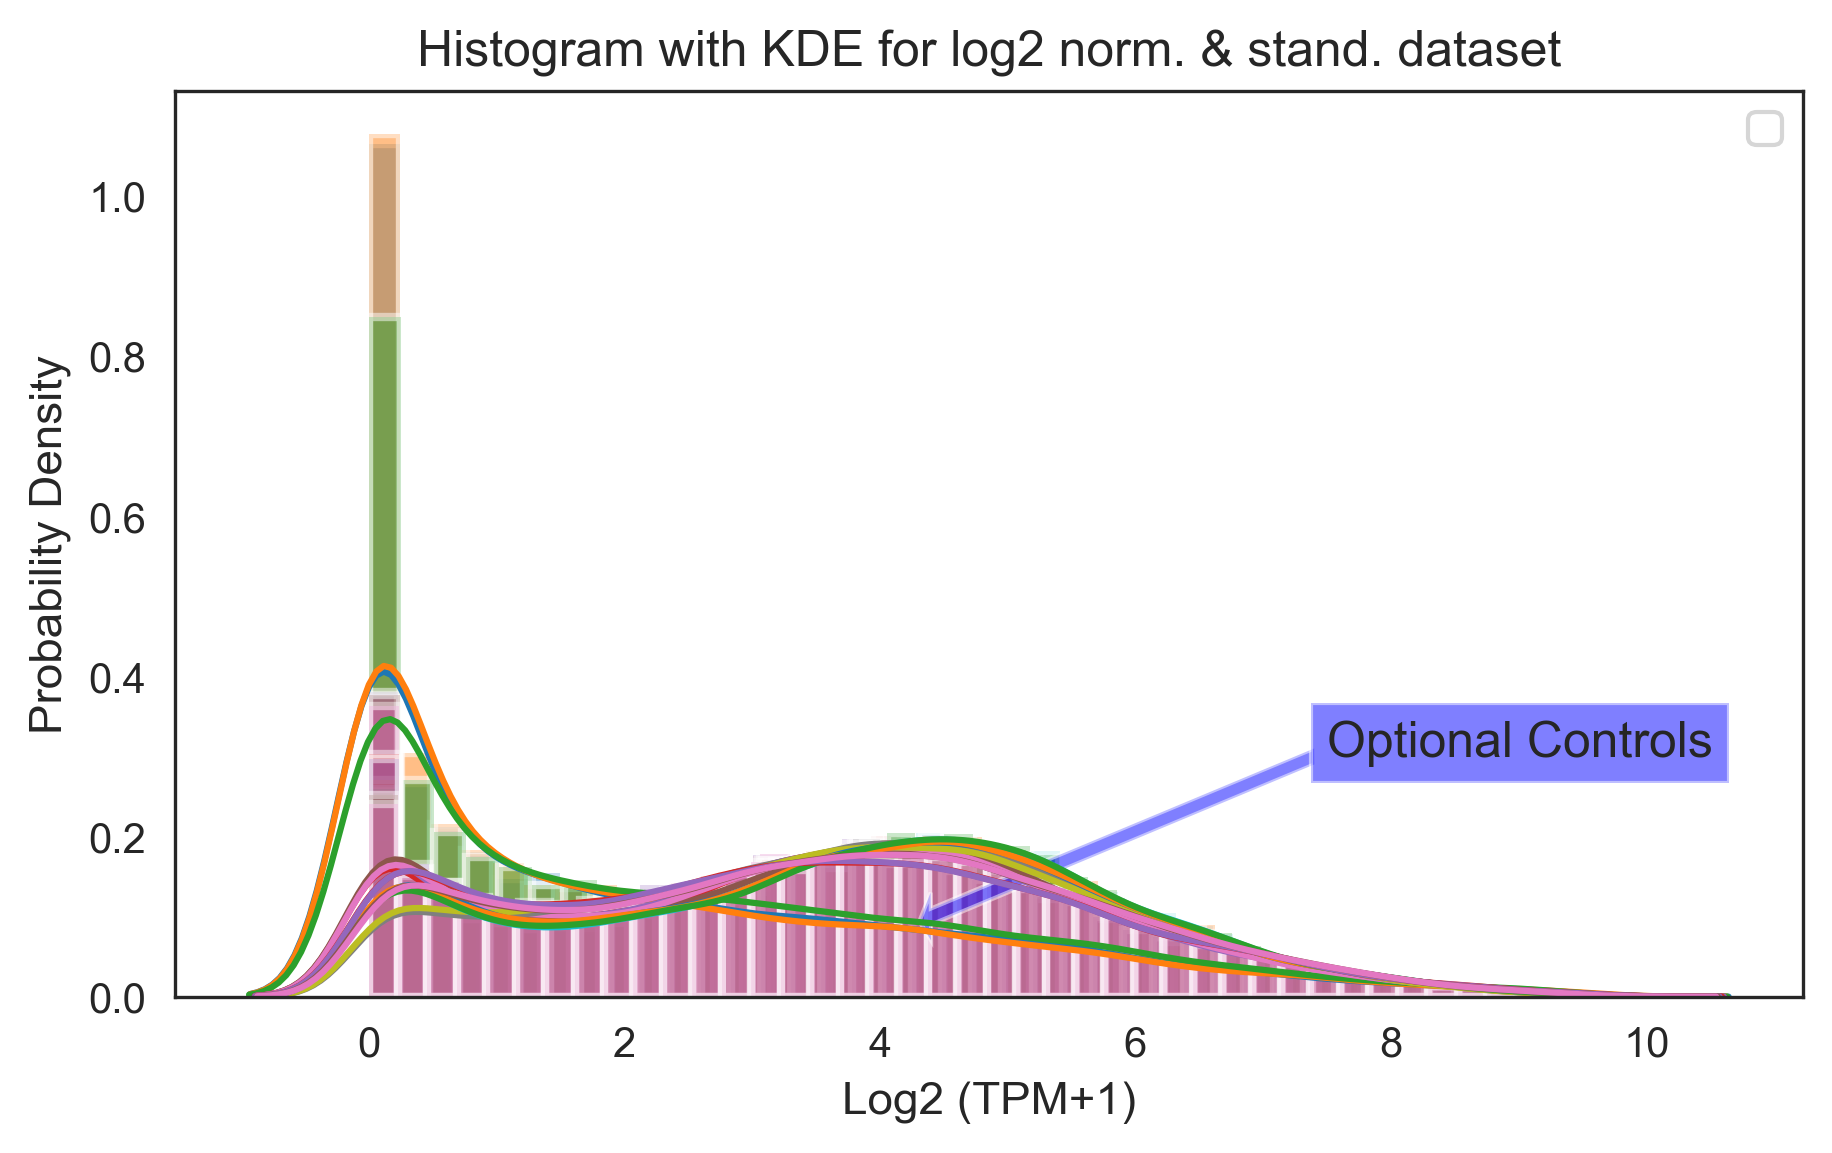

In [36]:
# plot the distribution
plot_KDE(df_plot, sample_lst, 'Log2 (TPM+1)')

Preparing series for all atypical


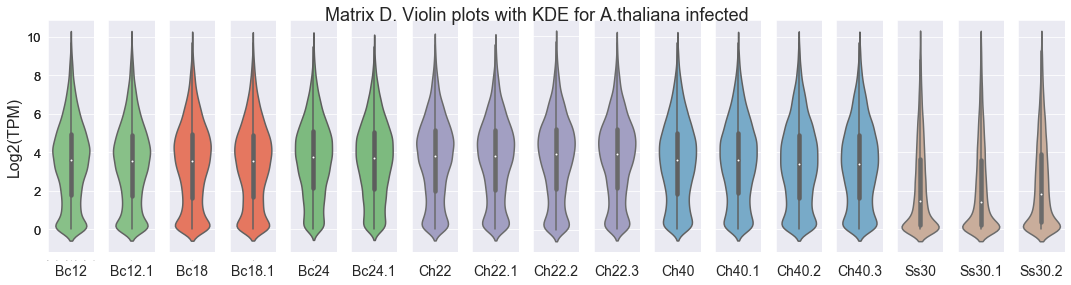

In [37]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
if general_titles == 'infected':
    violin_plot_inf(df_plot, "Matrix D", 0, False, 'Log2(TPM)')
    # @atypical: 
    #       0 = all samples
    #       1 = all with out atypical samples 
    #       2 = only atypical 
else:
    violin_plot_healthy(df_plot, "Matrix D", general_titles, False, 'Log(TPM)')   

## Let's get some stats over matrix D

In [38]:
df_stat = df_log.describe().T

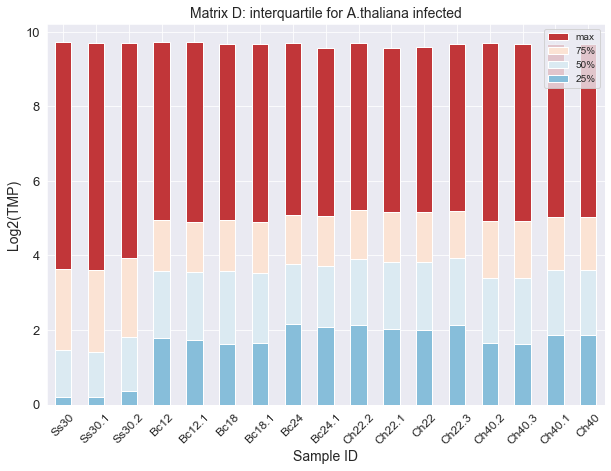

In [39]:
plot_intercuartile_bar(df_stat, 'Matrix D: interquartile for A.thaliana '+ general_titles, 'Log2(TMP)')

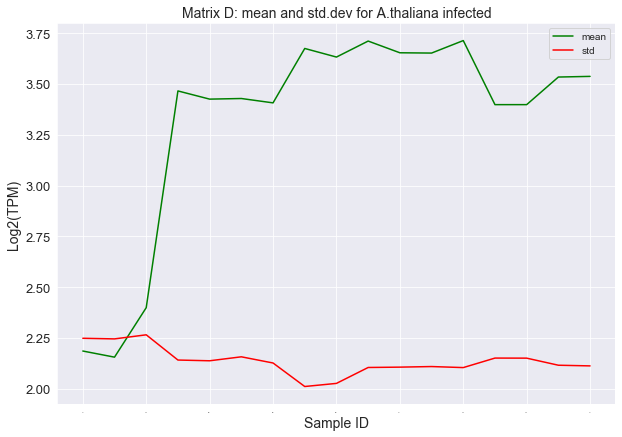

In [40]:
plot_mean_sdev_line(df_stat,'Matrix D: mean and std.dev for A.thaliana ' + general_titles,'Log2(TPM)')

In [41]:
lst_stat=df_stat['std'].to_list()
lst_stat.sort()
#lst_stat

In [42]:
#df_stat.to_csv("../statistics/matrix_D_stats_" + general_titles.strip() + ".csv", index=False, header=True)

## Looking for atypical distributions that can produce spurious correlations
** We are looking over the samples Ss30*** <br>
https://stackabuse.com/seaborn-violin-plot-tutorial-and-examples/

Preparing series for all atypical


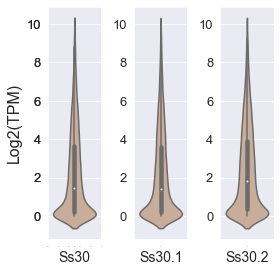

In [43]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_plot(df_log2, general_titles, 2, False, 'Log2(TPM) values')

# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
if general_titles == 'infected':
    violin_plot_inf(df_log, "Matrix D", 2, False, 'Log2(TPM)')

**Take an overview for central values and distributions for the entire dataset**

### Some stats for the atypical distributions: Ss30 
Let's remove them and analize the effect

In [44]:
df_log.head(2)
df_log.drop(['Ss30.1','Ss30.2','Ss30'], axis='columns', inplace=True)

In [45]:
print(len(df_log.columns))
df_log.head(2)

15


,Genes,Bc12,Bc12.1,Bc18,Bc18.1,Bc24,Bc24.1,Ch22.2,Ch22.1,Ch22,Ch22.3,Ch40.2,Ch40.3,Ch40.1,Ch40
0,AT1G01020,3.577,3.505,3.765,3.698,3.093,3.025,4.272,4.062,4.211,4.397,3.723,3.511,3.817,3.858
1,AT1G01030,0.813,1.604,1.881,2.031,2.400,2.559,1.389,1.187,1.199,1.103,1.386,1.471,1.145,1.700


**Some stats**

In [46]:
## save the stats of new matrix filtered
df_stat = df_log.describe().T
df_stat

,count,mean,std,min,25%,50%,75%,max
Bc12,20274.0,3.466,2.141,0.0,1.777,3.582,4.945,9.721
Bc12.1,20274.0,3.426,2.138,0.0,1.721,3.545,4.899,9.724
Bc18,20274.0,3.429,2.157,0.0,1.627,3.575,4.962,9.685
Bc18.1,20274.0,3.407,2.127,0.0,1.658,3.537,4.895,9.665
Bc24,20274.0,3.675,2.011,0.0,2.168,3.769,5.089,9.687
Bc24.1,20274.0,3.633,2.026,0.0,2.083,3.713,5.063,9.565
Ch22.2,20274.0,3.712,2.105,0.0,2.122,3.911,5.206,9.697
Ch22.1,20274.0,3.654,2.106,0.0,2.023,3.836,5.154,9.567
Ch22,20274.0,3.653,2.109,0.0,2.007,3.829,5.157,9.595
Ch22.3,20274.0,3.714,2.104,0.0,2.126,3.919,5.204,9.683


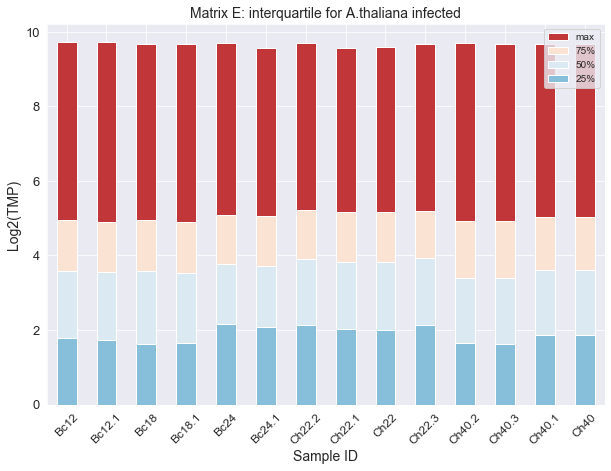

In [47]:
plot_intercuartile_bar(df_stat, 'Matrix E: interquartile for A.thaliana '+ general_titles, 'Log2(TMP)')

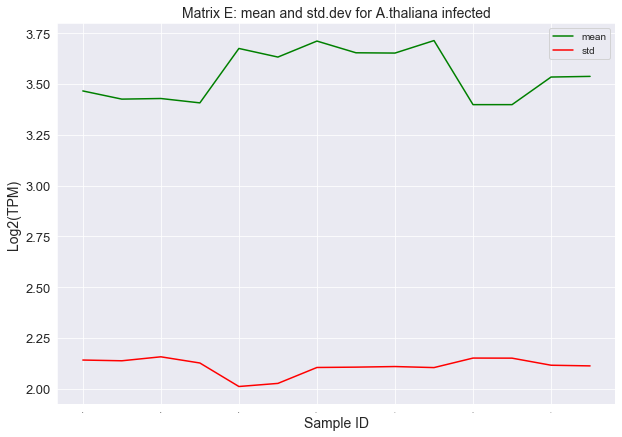

In [48]:
plot_mean_sdev_line(df_stat, 'Matrix E: mean and std.dev for A.thaliana '+ general_titles,'Log2(TPM)')

In [49]:
lst_stat=df_stat['mean'].to_list()
lst_stat.sort()
lst_stat

[3.3987412361749927,
 3.398784095090294,
 3.4074840768994035,
 3.425899957783014,
 3.428947990636155,
 3.466235907946446,
 3.5346639826161006,
 3.537900590693333,
 3.6330517499789843,
 3.652715824690205,
 3.6541368295702767,
 3.675368226873315,
 3.7117896202287013,
 3.714208233920904]

***KDE without the Ss30 samples***

In [50]:
sample_lst = df_log.columns.to_list()
sample_lst.remove('Genes')
sample_lst

['Bc12',
 'Bc12.1',
 'Bc18',
 'Bc18.1',
 'Bc24',
 'Bc24.1',
 'Ch22.2',
 'Ch22.1',
 'Ch22',
 'Ch22.3',
 'Ch40.2',
 'Ch40.3',
 'Ch40.1',
 'Ch40']

/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensi

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

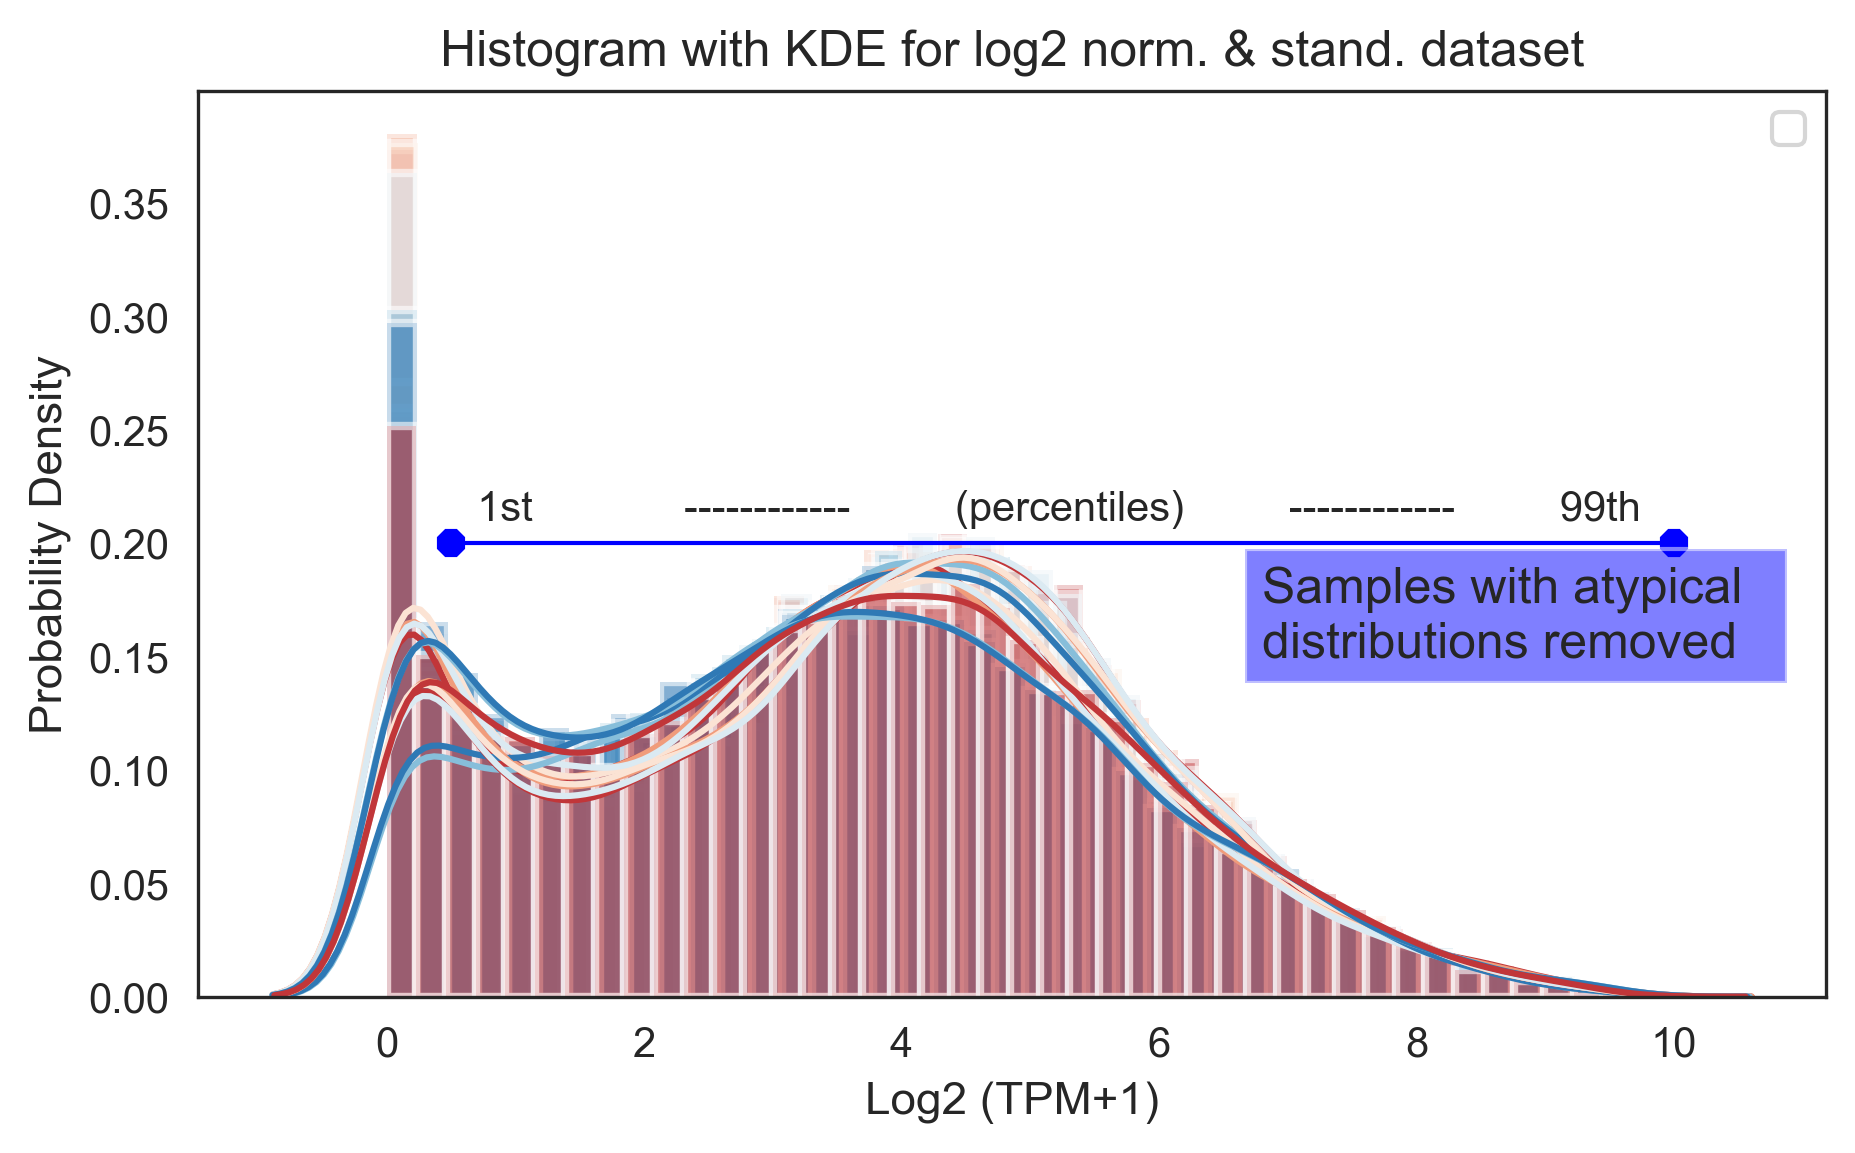

In [72]:
# plot the distribution
plot_KDE2(df_log, sample_lst, 'Log2 (TPM+1)')

***Violin plot with KDE without Ss30***

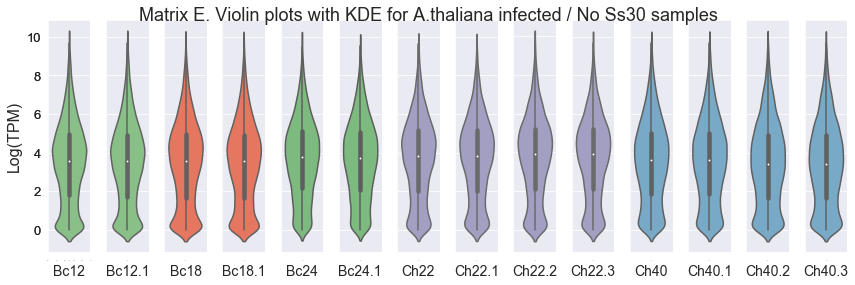

In [82]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
violin_plot_inf(df_log, "Matrix E", 1, False, 'Log(TPM)')

In [88]:
## save the new matrix E
#df_log.to_csv('matrix_E_'+ general_titles.strip() +'.csv', sep='\t', index=False)
#df_stat.to_csv("../statistics/matrix_E_stats_" + general_titles.strip() + ".csv", index=False, header=True)